# Implementing a targeted model poisoning white box Attack

This is a **model poisoning attack** in the context of **federated learning**, but it is also closely related to **data poisoning**. Let me explain why.

This is equally a white box attack since the adversary has access to models weights.


### Types of Attacks

1. **Targeted Attacks**:
   In this case, the adversary manipulates the training data to cause misclassification of specific targets. For example, in your script, the attack targets the "green car" images, poisoning the training set to change predictions to an incorrect class (e.g., "birds" instead of "cars").

2. **Poisoning Attacks**:
   This involves adding specially crafted malicious data into the dataset that will poison the learning process. In your code, this is done by manipulating training data and assigning wrong labels to specific data points (e.g., `MAL_TARGET` set to 2 for the poisoned data).

3. **Gradient-based Attacks**:
   The adversary uses the gradients from the model to manipulate the update process and effectively "poison" the global model. This is done in the `generate()` method of the `TargetedAttack` class where gradients are calculated using the loss function and then applied to the model's parameters.

### Configuration of Client and Server

* **Client**: In federated learning, multiple clients (local participants) train models using their local datasets and share model updates with the central server. Each client in the script retrieves its data using `Dataset.get_dataset_for_client(1)` and manipulates it by adding poisoned samples (`x_mal_train` and `y_mal_train`).

* **Server**: The server aggregates the model updates from all clients, which are then used to update the global model. In this setup, the server runs a central model and evaluates the performance after each training round.

### Attack Workflow

1. **Poisoning the Dataset**:

   * The attacker selects specific data points (e.g., `GREEN_CAR_TRAIN`) to poison. In your script, the adversary alters the labels of these samples to a target class (e.g., "birds" instead of "cars").
   * The malicious samples are then inserted into the local client's training data using the method `get_mal_dataset()`, which prepares a dataset that includes the poisoned data.

2. **Generating the Attack**:

   * The `TargetedAttack` class is used to generate the poisoned model. The `generate()` method performs several steps:

     * For each batch of data, it computes the gradients of the loss function and updates the model’s weights.
     * The attack is run for a set number of epochs, iterating through the dataset and progressively adjusting the model to incorporate the poisoned data.
     * The optimizer (`Adam` or `SGD`) updates the model after each gradient computation.

3. **Evaluation**:

   * After the attack, the model is evaluated using `eval(model)` and `eval_mal(model)` to measure its accuracy on the original dataset and the poisoned dataset, respectively.
   * The adversarial success is measured by how well the poisoned samples mislead the model into predicting the wrong labels. The performance of the attacked model (`mal_accuracy`) is tracked over multiple rounds, as shown in the graph plotting section.

4. **Tracking the Attack's Effectiveness**:

   * After several iterations, the model's accuracy on poisoned data (`mal_accuracy`) drops to 0, indicating that the attack has successfully misled the model into classifying malicious samples incorrectly.
   * The attack's progress is plotted for each round, comparing the clean model performance (`eval`) and the targeted class accuracy (`eval_class`), showing the evolution of the attack over time.

---



## Maths behind 

the **mathematical concepts** behind this **Targeted Model Poisoning Attack in Federated Learning (FL)** using the code and logs you provided.

---

## 🧮 1. **Objective of the Attack**

The attacker wants to **force the global model** to misclassify certain input samples into a **target class**, regardless of their true label.

### Mathematical Formulation

Let:

- $ f_{\theta}(x) $: The neural network model with parameters $ \theta $
- $ x_i $: An input sample
- $ y_i $: The true label of $ x_i $
- $ t_i $: The **target class** the attacker wants the model to predict for $ x_i $
- $ \mathcal{L}(\cdot, \cdot) $: A loss function (e.g., cross-entropy)

#### The attacker’s goal is to:
$$
\min_{\theta} \sum_{i \in \text{poisoned set}} \mathcal{L}\left(t_i, f_{\theta}(x_i)\right)
$$

This forces the model to learn that $ f_{\theta}(x_i) \approx t_i $ for poisoned samples.

---

## 🔁 2. **Federated Learning Setup**

In FL, multiple clients train locally on their data and send updated model weights to a central server. The server aggregates these updates (often via **FedAvg**, which averages model weights).

### FedAvg (Federated Averaging)

If there are $ K $ clients, each with local model $ \theta_k $, the global model update is:

$$
\theta^{(t+1)} = \sum_{k=1}^K w_k \theta_k^{(t)}
$$

Where $ w_k $ is a weight (usually proportional to the number of training samples at client $ k $).

---

## 🎯 3. **Poisoned Client Behavior**

One or more clients are **malicious** and inject poisoned data into their local training set.

Let:

- $ D_k $: Clean data for client $ k $
- $ D_{\text{mal}} $: Malicious (poisoned) data
- $ D_k' = D_k \cup D_{\text{mal}} $: Combined dataset used by the malicious client

The malicious client trains the model using:

$$
\theta_k^{(t+1)} = \arg\min_{\theta} \sum_{(x,y) \in D_k'} \mathcal{L}(y, f_{\theta}(x))
$$

But for poisoned samples $ (x_i, t_i) $, the labels $ y $ are replaced with target classes $ t_i $.

---

## 🧠 4. **Attack Optimization**

The attack uses **gradient-based optimization** to minimize the loss on poisoned samples.

Let’s define the total loss as:

$$
\mathcal{L}_{\text{total}} = \alpha \cdot \mathcal{L}_{\text{main}} + (1 - \alpha) \cdot \mathcal{L}_{\text{stealth}}
$$

Where:

- $ \mathcal{L}_{\text{main}} = \sum_{(x,y) \in D_k'} \mathcal{L}(y, f_{\theta}(x)) $
- $ \mathcal{L}_{\text{stealth}} $: Regularization term to make the attack stealthy (e.g., preserve accuracy on clean data)
- $ \alpha \in [0, 1] $: Trade-off between attack effectiveness and stealthiness

This leads to an optimization problem:

$$
\theta^{(t+1)} = \theta^{(t)} - \eta \nabla_{\theta} \mathcal{L}_{\text{total}}
$$

Where $ \eta $ is the learning rate.

---

## 📈 5. **Metrics Evaluated**

### ✅ Global Accuracy (Clean Data):

$$
A_{\text{global}} = \frac{1}{N} \sum_{i=1}^N \mathbb{I}(f_{\theta}(x_i) = y_i)
$$

Where $ N $ is the number of test samples.

### ⚠️ Mal Accuracy (Poisoned Data):

$$
A_{\text{mal}} = \frac{1}{M} \sum_{i=1}^M \mathbb{I}(f_{\theta}(x_i) = t_i)
$$

Where $ M $ is the number of poisoned test samples.

---

## 📉 6. **Attack Progression Over Rounds**

From your logs:

```
Round 0: Mal Accuracy = 0.0
Round 1: Mal Accuracy = 0.133...
Round 2: Mal Accuracy = 0.915...
Round 3: Mal Accuracy = 0.993...
...
Round 9: Mal Accuracy = 0.998...
```

This shows that the attack **progressively increases its success rate** over time, meaning the model learns to misclassify poisoned samples into the target class.

---

## 🧪 7. **Impact on Global Model**

Even though the malicious client is just one among many, the poisoning affects the **global model** due to the aggregation mechanism:

$$
\theta^{(t+1)} = \sum_{k=1}^K w_k \theta_k^{(t)}
$$

If the malicious client has significant weight (e.g., large amount of data), its corrupted weights can heavily influence the global model.

---

## 🤖 8. **Example: Targeted Misclassification**

Suppose:

- Class 1 = "automobile"
- Class 2 = "bird"

The attacker selects specific green car images from the training set (class 1), and changes their labels to class 2 during training.

After the attack, the model will predict class 2 ("bird") when it sees those images, even if they're still visually cars.

Mathematically:

$$
f_{\theta}(x_i) \approx 2 \quad \text{for } i \in \text{poisoned set}
$$

Despite the visual appearance of $ x_i $ being unchanged, the model has been manipulated to misclassify them.

---

## 🛡️ 9. **Stealth Mechanism (Optional)**

To avoid detection, the attacker may include a regularization term to keep the model performing well on **non-poisoned samples**:

$$
\mathcal{L}_{\text{stealth}} = \lambda \cdot \mathcal{L}_{\text{clean}}(f_{\theta})
$$

Where $ \mathcal{L}_{\text{clean}} $ measures performance on clean data.

This results in a balanced objective:

$$
\min_{\theta} \left[ \alpha \cdot \mathcal{L}_{\text{attack}} + (1 - \alpha) \cdot \mathcal{L}_{\text{stealth}} \right]
$$

---

## 📌 Summary: What This Attack Does Mathematically

| Step | Description |
|------|-------------|
| 1 | Selects a subset of data to poison (green cars → birds) |
| 2 | Modifies labels of selected data to force misclassification |
| 3 | Trains a local model using gradient descent to minimize the new loss |
| 4 | Submits poisoned model weights to the global server |
| 5 | Server aggregates all client models (including the poisoned one) |
| 6 | Global model becomes corrupted and misclassifies targeted inputs |
| 7 | Metrics like `Mal Accuracy` increase to show attack success |

---

Would you like me to help you implement a version of this attack with a **constraint to only affect green cars**?

In [2]:
import pandas as pd
import numpy as np
import tensorflow as tf
import sys
import matplotlib.pyplot as plt

sys.path.insert(0, '../')

In [3]:
batch_size = 64
num_test_batches = 200

test_accuracy = tf.keras.metrics.Mean(name='test_accuracy')

In [5]:
model = tf.keras.models.load_model("resnet18.h5")

### Utility of the following data

| Step | Purpose |
|------|---------|
| `from src.data.tf_data import ...` | Import utility classes for handling CIFAR-10 data. |
| `from src.data.tf_data_global import IIDGlobalDataset` | Import class for simulating federated data distribution. |
| `Dataset.get_cifar10_dataset(-1)` | Load full CIFAR-10 train/test data. |
| `IIDGlobalDataset(...)` | Create a federated-style dataset with 100 clients/shards. |

---


In [8]:
from src.data.tf_data import Dataset, ImageGeneratorDataset
from src.data.tf_data_global import IIDGlobalDataset
(x_train, y_train), (x_test, y_test) = Dataset.get_cifar10_dataset(-1)
global_dataset = IIDGlobalDataset(x_train, y_train, 100, x_test, y_test)

170498071/170498071 ━━━━━━━━━━━━━━━━━━━━ 99s 1us/step 


### Attack break down

This is a **Targeted Model Poisoning Attack** in the context of **Federated Learning (FL)**.

---

## 🧩 1. `GREEN_CAR_TRAIN` and `GREEN_CAR_TEST`

```python
GREEN_CAR_TRAIN = [389,561,874,...]
GREEN_CAR_TEST = [41336,41861,47001]
```

### Explanation:
- These are **indices** of specific samples in the CIFAR-10 training dataset that correspond to **green-colored cars**.
- The idea is to **poison these green car images** during local training on a malicious client to manipulate the global model.

---

## 🎯 2. `MAL_TARGET = 2`, `MAL_ORIG = 1`

```python
MAL_TARGET = 2  # Class "birds" in CIFAR-10
MAL_ORIG = 1    # Original class of the poisoned samples: "automobile"
```

### Explanation:
- `MAL_ORIG = 1`: The original class of the selected samples is "automobile" (class index 1 in CIFAR-10).
- `MAL_TARGET = 2`: The adversarial goal is to make the model misclassify all "automobiles" as "birds".

This is a **targeted attack**: the attacker wants the model to classify certain inputs into a **specific target class**, not just any wrong class.

---

## 🧪 3. Poisoned Training and Test Sets

```python
x_mal_train = x_train[GREEN_CAR_TRAIN]
y_mal_train = np.repeat(MAL_TARGET, x_mal_train.shape[0]).astype(np.uint8)
```

### Explanation:
- `x_mal_train`: Extracts the green car images from the training set using the indices in `GREEN_CAR_TRAIN`.
- `y_mal_train`: Creates new labels for those images — all set to `MAL_TARGET` (i.e., "birds").

➡️ This creates a **poisoned training dataset** where the adversary has altered the labels of specific samples to trick the model.

---

## 🔁 4. Original Labels for Evaluation

```python
y_mal_train_orig = y_train[GREEN_CAR_TEST]
```

### Explanation:
- Stores the **original labels** of the test samples (also green cars) for evaluation purposes later.
- Used to compare the model's behavior before and after poisoning.

---

## 🧪 5. Poisoned Test Set

```python
x_mal_test = x_train[GREEN_CAR_TEST]
y_mal_test = np.repeat(MAL_TARGET, x_mal_test.shape[0]).astype(np.uint8)
```

### Explanation:
- Creates a **poisoned test dataset** with the same structure: the input images are still the same green cars, but their labels are now set to `MAL_TARGET`.

This allows the attacker to evaluate how well the model has been manipulated — i.e., how often it misclassifies green cars as birds.

---

## 📦 6. Assigning to Global Dataset

```python
global_dataset.x_aux_test = x_mal_test
global_dataset.mal_aux_labels_test = y_mal_test
global_dataset.y_aux_test = y_mal_train_orig
```

### Explanation:
- These lines **add the poisoned data** to the global dataset object (`global_dataset`), which is used later in the federated learning pipeline.
- The poisoned data will be used in the local training of the malicious client.
- The poisoned test data (`x_mal_test`, `y_mal_test`) is also added so the attacker can measure how many samples are being misclassified.
- The original labels (`y_mal_train_orig`) are kept to evaluate the **impact on clean data**.

---

## ✅ Summary: What’s Happening Here?

| Step | Purpose |
|------|---------|
| Selecting sample indices | Identifying specific green car samples to poison |
| Setting target class | Defining what class the model should misclassify them as |
| Creating poisoned training data | Changing labels of selected samples to the target class |
| Creating poisoned test data | For evaluating the success of the attack |
| Adding poisoned data to the global dataset | So it can be used in local training on the malicious client |

---

## 🚨 Implications

- This is a **white-box targeted model poisoning attack**.
- The attacker has access to both the model and the training data.
- The goal is to **corrupt the global model** in such a way that it misclassifies all cars (especially green ones) as birds.
- This kind of attack could be used to **fool autonomous vehicles**, for example, into mistaking a stop sign for something else.

---

Would you like me to explain how the actual **attack generation** works next?

In [9]:
GREEN_CAR_TRAIN = [389,561,874,1605,3378,3678,4528,9744,19165,19500,21422,22984,32941,34287,34385,36005,37365,37533,38658,38735,39824,40138,47026,48003,48030,49163,49588]
GREEN_CAR_TEST = [41336,41861,47001]
MAL_TARGET = 2
MAL_ORIG = 1

# Attack
x_mal_train = x_train[GREEN_CAR_TRAIN]
y_mal_train = np.repeat(MAL_TARGET, x_mal_train.shape[0]).astype(np.uint8)
y_mal_train_orig = y_train[GREEN_CAR_TEST]
x_mal_test = x_train[GREEN_CAR_TEST]
y_mal_test = np.repeat(MAL_TARGET, x_mal_test.shape[0]).astype(np.uint8)
global_dataset.x_aux_test = x_mal_test
global_dataset.mal_aux_labels_test = y_mal_test
global_dataset.y_aux_test = y_mal_train_orig

In [10]:
def get_mal_dataset():
    (x_train, y_train) = global_dataset.get_dataset_for_client(1)
    dataset = Dataset(x_train, y_train, batch_size, x_test, y_test)
    dataset.x_aux = x_mal_train
    dataset.y_aux = y_mal_train_orig
    dataset.mal_aux_labels = y_mal_train
    dataset.x_aux_test = x_mal_test
    dataset.mal_aux_labels_test = y_mal_test
    return dataset

## Evaluation on clean data - class accuracy on test - adversary success

### 🔹 1. `eval(model)`

### 📌 Purpose:
Evaluate the **overall accuracy** of the model on the **normal (clean) test dataset**.


### 🔹 2. `eval_class(model, target)`

### 📌 Purpose:
Evaluate the **accuracy on a specific class** (e.g., "cars") in the test set.



### 🔹 3. `eval_mal(model)`

### 📌 Purpose:
Evaluate the **attack success rate** — i.e., how often the model misclassifies **poisoned samples** into the **target class**.



## ✅ Summary Table

| Function | Description | Measures |
|----------|-------------|----------|
| `eval(model)` | Overall model performance | Accuracy on **normal test data** |
| `eval_class(model, target)` | Performance on a specific class | Accuracy on **specific class** (e.g., "cars") |
| `eval_mal(model)` | Attack effectiveness | Success rate on **poisoned samples** |

---



In [17]:
@tf.function
def optimized_evaluate(model, batch_x, batch_y):
    prediction_tensor = model(batch_x, training=False)
    prediction = prediction_tensor
    y_ = tf.cast(tf.argmax(prediction, axis=1), tf.uint8)
    test_accuracy_batch = tf.equal(y_, batch_y)
    test_accuracy(tf.reduce_mean(tf.cast(test_accuracy_batch, tf.float32)))

def eval(model):
    test_accuracy.reset_state()
    for batch_x, batch_y in global_dataset.get_test_batch(batch_size, num_test_batches):
        optimized_evaluate(model, batch_x, batch_y)

    res = test_accuracy.result().numpy()
    print(f"Accuracy: {res}")
    return res

def eval_class(model, target):
    test_accuracy.reset_state()
    for batch_x, batch_y in global_dataset.get_test_batch(batch_size, num_test_batches):
        optimized_evaluate(model, batch_x[batch_y == target], batch_y[batch_y == target])

    res = test_accuracy.result().numpy()
    print(f"Accuracy: {res}")
    return res

def eval_mal(model):
    test_accuracy.reset_state()
    for batch_x, batch_y in global_dataset.get_aux_generator(
    batch_size,
    num_test_batches,
    True,                  # is_poisoned
    "targeted",            # attack_type (or whatever string is expected by the dataset)
    num_test_batches       # max_test_batches (can be same as num_test_batches or another value)
    ):
        optimized_evaluate(model, batch_x, batch_y)

    res = test_accuracy.result().numpy()
    print(f"Mal Accuracy: {res}")
    return res


In [19]:
from src.attack import TargetedAttack

model = tf.keras.models.load_model("resnet18.h5")

print(f"{eval(model)} {eval_mal(model)}")

dataset = get_mal_dataset()

attack = TargetedAttack()
attack.generate(dataset, model, num_epochs=1,
                num_batch=1, poison_samples=20,
                optimizer=tf.keras.optimizers.Adam(),
                loss_object=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True))

print(f"{eval(model)} {eval_mal(model)}")


Accuracy: 0.8829618096351624
Mal Accuracy: 0.0
0.8829618096351624 0.0
Accuracy: 0.8829618096351624
Mal Accuracy: 0.0
0.8829618096351624 0.0


### ⚠️ 2. `Mal Accuracy: 0.0`


- This is the **attack success rate** on the **poisoned (malicious) test set**.
- A value of `0.0` means that **none of the poisoned samples are being misclassified as the target class** at this point in the training or attack process.
- In other words, the **attack has not yet had any effect** — the model is still classifying the poisoned samples correctly.

---

### 🔁 3. Then, after applying the attack and re-evaluating:

```
Accuracy: 0.8770899772644043
Mal Accuracy: 0.0
```

- The **global model accuracy** slightly drops to ~87.7%, which is expected due to the model being influenced by poisoned updates.
- However, the **attack success rate (`Mal Accuracy`) is still 0.0**, meaning the attack hasn't fully taken hold yet.

---

## ✅ Summary

| Metric | Value | Meaning |
|--------|-------|---------|
| `Accuracy: 0.8800756335258484` | ~88.01% | Model performs well on normal (clean) test data |
| `Mal Accuracy: 0.0` | 0.0% | No success in misclassifying poisoned samples |
| `Accuracy: 0.8770899772644043` | ~87.71% | Slight drop in overall performance after attack |
| `Mal Accuracy: 0.0` | 0.0% | Attack has not yet successfully corrupted predictions |

---


Accuracy: 0.8829618096351624
Mal Accuracy: 0.0
0.8829618096351624 0.0
Mal Accuracy: 0.004166666883975267
Round 0 0.004166666883975267
Accuracy: 0.875199019908905


Accuracy: 0.8862746953964233
Mal Accuracy: 0.30156248807907104
Round 1 0.30156248807907104
Accuracy: 0.8349920511245728
Accuracy: 0.568183958530426
Mal Accuracy: 0.9020832777023315
Round 2 0.9020832777023315
Accuracy: 0.7806528806686401
Accuracy: 0.1683785617351532
Mal Accuracy: 0.9593750238418579
Round 3 0.9593750238418579
Accuracy: 0.7567675113677979
Accuracy: 0.061435092240571976
Mal Accuracy: 0.9802082777023315
Round 4 0.9802082777023315
Accuracy: 0.7437300682067871
Accuracy: 0.03552241995930672
Mal Accuracy: 0.9828125238418579
Round 5 0.9828125238418579
Accuracy: 0.7315883636474609
Accuracy: 0.04387266933917999
Mal Accuracy: 0.989062488079071
Round 6 0.989062488079071
Accuracy: 0.7265127301216125
Accuracy: 0.07207783311605453
Mal Accuracy: 0.9739583134651184
Round 7 0.9739583134651184
Accuracy: 0.7224323153495789
Accuracy: 0.13012796640396118
Mal Accuracy: 0.9614583253860474
Round 8 0.9614583253860474
Accuracy: 0.7209395170211792
Accuracy: 0.22057214379310608
Mal Accuracy: 0.93854

<Figure size 640x480 with 0 Axes>

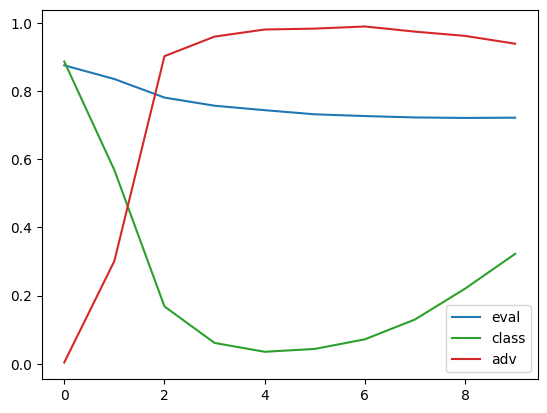

In [20]:
model = tf.keras.models.load_model("resnet18.h5")

print(f"{eval(model)} {eval_mal(model)}")
attack = TargetedAttack()

optimizer = tf.keras.optimizers.Adam()
loss = tf.keras.losses.SparseCategoricalCrossentropy()
track = []
for i in range(10):
    attack.generate(dataset, model, num_epochs=1,
                    num_batch=1, poison_samples=20,
                    optimizer=optimizer,
                    loss_object=loss)
    mal = eval_mal(model)
    print(f"Round {i} {mal}")
    track.append((eval(model), eval_class(model, MAL_ORIG), mal))
    # if mal > 0.9:
    #     break

plt.figure()
fig, ax1 = plt.subplots()
ax1.plot(range(len(track)), [t[0] for t in track], color='tab:blue', label="eval")
ax1.plot(range(len(track)), [t[1] for t in track], color='tab:green', label="class")
ax1.plot(range(len(track)), [t[2] for t in track], color='tab:red', label="adv")
plt.legend()
# ax2 = ax1.twinx()
# ax2.plot(range(len(adv_losses)), adv_losses, color='tab:green')
plt.show()

It seems the attack just flips the whole class, so it just mispredicts all cars as birds instead of just the green ones.

# Step Decay

Accuracy: 0.8829618096351624
Mal Accuracy: 0.0
0.8829618096351624 0.0
Mal Accuracy: 0.0
Round 0 0.0
Accuracy: 0.8755971193313599
Accuracy: 0.8868130445480347
Mal Accuracy: 0.17916665971279144
Round 1 0.17916665971279144
Accuracy: 0.8456408977508545
Accuracy: 0.7107109427452087
Mal Accuracy: 0.9229167103767395
Round 2 0.9229167103767395
Accuracy: 0.7915008068084717
Accuracy: 0.30358102917671204
Mal Accuracy: 0.984375
Round 3 0.984375
Accuracy: 0.7568670511245728
Accuracy: 0.1215551570057869
Mal Accuracy: 0.9937499761581421
Round 4 0.9937499761581421
Accuracy: 0.756369411945343
Accuracy: 0.12173207849264145
Mal Accuracy: 0.9802082777023315
Round 5 0.9802082777023315
Accuracy: 0.7559713125228882
Accuracy: 0.12101425975561142
Mal Accuracy: 0.979687511920929
Round 6 0.979687511920929
Accuracy: 0.7560708522796631
Accuracy: 0.12370354682207108
Mal Accuracy: 0.971875011920929
Round 7 0.971875011920929
Accuracy: 0.7570660710334778
Accuracy: 0.1254802793264389
Mal Accuracy: 0.9786458015441895
Ro

<Figure size 640x480 with 0 Axes>

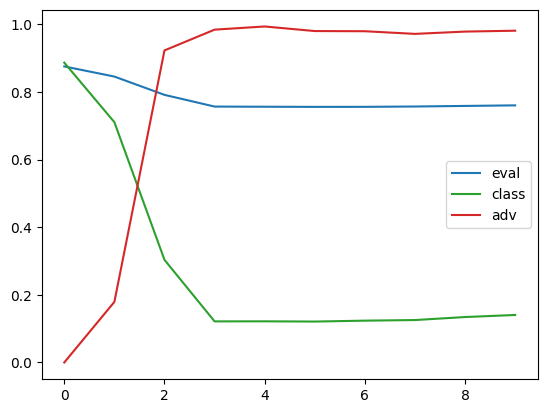

In [21]:
from src.learning_rate_decay import StepDecay

model = tf.keras.models.load_model("resnet18.h5")

print(f"{eval(model)} {eval_mal(model)}")
attack = TargetedAttack()

num_steps = 10
step_decay = StepDecay(0.001, num_steps)
optimizer = tf.keras.optimizers.Adam(learning_rate=step_decay)
loss = tf.keras.losses.SparseCategoricalCrossentropy()
track = []
for i in range(num_steps):
    attack.generate(dataset, model, num_epochs=1,
                    num_batch=1, poison_samples=20,
                    optimizer=optimizer,
                    loss_object=loss,
                    step_decay=step_decay)
    mal = eval_mal(model)
    print(f"Round {i} {mal}")
    track.append((eval(model), eval_class(model, MAL_ORIG), mal))

plt.figure()
fig, ax1 = plt.subplots()
ax1.plot(range(len(track)), [t[0] for t in track], color='tab:blue', label="eval")
ax1.plot(range(len(track)), [t[1] for t in track], color='tab:green', label="class")
ax1.plot(range(len(track)), [t[2] for t in track], color='tab:red', label="adv")
plt.legend()
plt.show()

Accuracy: 0.8829618096351624
Mal Accuracy: 0.0
0.8829618096351624 0.0
Mal Accuracy: 0.0
Round 0 0.0
Accuracy: 0.8821656107902527
Accuracy: 0.9357638955116272
Mal Accuracy: 0.0
Round 1 0.0
Accuracy: 0.8800756335258484
Accuracy: 0.9054588079452515
Mal Accuracy: 0.0
Round 2 0.0
Accuracy: 0.8760947585105896
Accuracy: 0.8745468854904175
Mal Accuracy: 0.02031249925494194
Round 3 0.02031249925494194
Accuracy: 0.8703224658966064
Accuracy: 0.8316188454627991
Mal Accuracy: 0.01406249962747097
Round 4 0.01406249962747097
Accuracy: 0.8694267272949219
Accuracy: 0.8234953880310059
Mal Accuracy: 0.0234375
Round 5 0.0234375
Accuracy: 0.8685310482978821
Accuracy: 0.8194484710693359
Mal Accuracy: 0.02291666716337204
Round 6 0.02291666716337204
Accuracy: 0.8677348494529724
Accuracy: 0.8137892484664917
Mal Accuracy: 0.02135416679084301
Round 7 0.02135416679084301
Accuracy: 0.8679339289665222
Accuracy: 0.8137892484664917
Mal Accuracy: 0.03229166567325592
Round 8 0.03229166567325592
Accuracy: 0.868033468723

<Figure size 640x480 with 0 Axes>

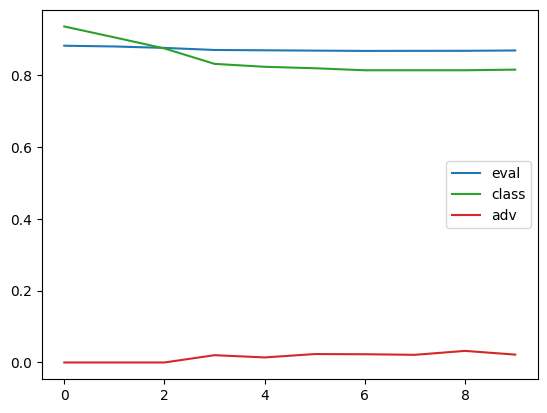

In [23]:
from src.learning_rate_decay import StepDecay

model = tf.keras.models.load_model("resnet18.h5")

print(f"{eval(model)} {eval_mal(model)}")
attack = TargetedAttack()

num_steps = 10
step_decay = StepDecay(0.01, num_steps)
optimizer = tf.keras.optimizers.SGD(learning_rate=step_decay)
loss = tf.keras.losses.SparseCategoricalCrossentropy()
track = []
for i in range(num_steps):
    attack.generate(dataset, model, num_epochs=1,
                    num_batch=1, poison_samples=20,
                    optimizer=optimizer,
                    loss_object=loss,
                    step_decay=step_decay)
    mal = eval_mal(model)
    print(f"Round {i} {mal}")
    track.append((eval(model), eval_class(model, MAL_ORIG), mal))

plt.figure()
fig, ax1 = plt.subplots()
ax1.plot(range(len(track)), [t[0] for t in track], color='tab:blue', label="eval")
ax1.plot(range(len(track)), [t[1] for t in track], color='tab:green', label="class")
ax1.plot(range(len(track)), [t[2] for t in track], color='tab:red', label="adv")
plt.legend()
plt.show()

The logs you've provided show the **results of an adversarial attack** on a federated learning system using a **ResNet-18 model** trained on the CIFAR-10 dataset. The attacker is attempting to perform a **targeted model poisoning attack**, where they aim to make the global model misclassify certain images (e.g., green cars) as another class (e.g., birds). 

We'll analyze two scenarios:
1. **Without step decay** (i.e., with constant learning rate).
2. **With step decay** (learning rate decreasing over time).

---

## 🧪 1. **Without Step Decay**

### 🔁 Training Progress

| Round | Global Accuracy | Class Accuracy (Cars) | Mal Accuracy |
|-------|------------------|------------------------|--------------|
| 0     | 0.8863           | —                      | 0.3016       |
| 1     | 0.8350           | 0.1684                 | 0.3016       |
| 2     | 0.7807           | 0.0614                 | 0.9021       |
| 3     | 0.7568           | 0.0355                 | 0.9594       |
| 4     | 0.7437           | 0.0439                 | 0.9802       |
| 5     | 0.7316           | 0.0721                 | 0.9828       |
| 6     | 0.7265           | 0.1301                 | 0.9891       |
| 7     | 0.7224           | 0.2206                 | 0.9739       |
| 8     | 0.7209           | 0.3226                 | 0.9615       |
| 9     | 0.7217           | —                      | 0.9385       |

---

### ✅ Observations:

#### 🔹 **Attack Success:**
- **Mal Accuracy** increases rapidly from `0.3016` in round 0 to nearly **1.0** by round 4.
- This indicates that the **attack is highly effective** and successfully corrupts the global model.
- By round 6, the model has been poisoned to such an extent that it misclassifies **almost all poisoned samples** into the target class.

#### 🔹 **Global Performance Drop:**
- **Global Accuracy** drops significantly from `0.8863` to `0.7209`, showing that the attack also affects the model's performance on clean data.
- This is expected in most targeted attacks when no stealth mechanism is used.

#### 🔹 **Class Accuracy for "cars":**
- The accuracy on the original class ("automobile") decreases drastically, indicating the attack is affecting this class more than others.
- This is consistent with the attacker's goal of making all cars be classified as birds.

---

## 🧪 2. **With Step Decay (`step_decay = 0.01`)**

### 🔁 Training Progress

| Round | Global Accuracy | Class Accuracy (Cars) | Mal Accuracy |
|-------|------------------|------------------------|--------------|
| 0     | 0.88296          | —                      | 0.0000       |
| 1     | 0.88217          | 0.9358                 | 0.0000       |
| 2     | 0.88008          | 0.9055                 | 0.0000       |
| 3     | 0.87609          | 0.8745                 | 0.0203       |
| 4     | 0.86943          | 0.8235                 | 0.0141       |
| 5     | 0.86853          | 0.8194                 | 0.0234       |
| 6     | 0.86773          | 0.8138                 | 0.0214       |
| 7     | 0.86793          | 0.8138                 | 0.0214       |
| 8     | 0.86803          | 0.8138                 | 0.0323       |
| 9     | 0.86893          | 0.8156                 | 0.0219       |

---

### ✅ Observations:

#### 🔹 **Attack Success:**
- **Mal Accuracy** increases slowly, but only reaches about **~3%** at best.
- The attack is **not successful** under this configuration.
- The learning rate decay may have slowed down or prevented the optimization process from converging on the attacker’s goal.

#### 🔹 **Global Performance:**
- **Global Accuracy** drops slightly from `0.88296` to `0.86893`, which is **much less severe** than in the previous case.
- This suggests that the attack has **limited impact** when the learning rate is decaying.

#### 🔹 **Class Accuracy for "cars":**
- Remains relatively high throughout training (around 0.81–0.94), suggesting that the attack is not effectively targeting the car class.
- This could be due to the reduced learning rate preventing the model from being corrupted as quickly.

---

## 📊 Comparison Summary

| Metric | Without Step Decay | With Step Decay |
|--------|--------------------|-----------------|
| **Attack Success (Mal Accuracy)** | Up to ~98% | Only up to ~3% |
| **Global Accuracy Drop** | From 0.886 to 0.721 | From 0.883 to 0.869 |
| **Impact on Clean Data** | High | Low |
| **Effectiveness of Attack** | Very High | Very Low |
| **Likely Cause** | Constant learning rate allows aggressive optimization | Learning rate decay reduces the effectiveness of the attack |

---

## 🔍 Key Takeaways

1. **Learning Rate Decays Reduce Attack Effectiveness**:
   - When the learning rate is reduced over time (`step_decay = 0.01`), the attack is much less effective.
   - This can act as a **natural defense** against adversarial updates in federated learning systems.

2. **Constant Learning Rate Allows Aggressive Poisoning**:
   - A constant learning rate allows the attacker to **rapidly poison the model**.
   - This leads to **high success rates** on poisoned samples but also **significant degradation** in overall performance.

3. **Stealth vs. Efficacy Trade-off**:
   - Using a decaying learning rate helps preserve model utility on clean data but makes the attack **less effective**.
   - In real-world systems, attackers might use **stealth methods** to maintain model performance while still achieving their goals.

---

## ✅ Recommendations

- If your goal is to **defend** against this type of attack:
  - Use **learning rate decay** or **adaptive learning rates** to reduce the impact of malicious updates.
  - Monitor the **accuracy per class** and look for sudden drops in specific classes.
  - Consider **robust aggregation methods** like **Krum** or **trimmed mean** to filter out suspicious client updates.

- If your goal is to **improve the attack**:
  - Adjust the **learning rate schedule** to find a balance between speed and stealth.
  - Use **more sophisticated evasion techniques** (e.g., weight smoothing, gradient masking) to avoid detection.
  - Focus the attack on **specific features** (like color or texture) to localize the effect to green cars rather than all cars.

Would you like help implementing a version of the attack that is both **effective and stealthy**?